Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period , identify which factors predict future user adoption.

In [1]:
import pandas as pd
from datetime import datetime
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesClassifier
pd.options.display.max_colwidth = 200

First lets import the data and take a look at how it's organized.

In [2]:
df_users = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1')
print(df_users.info())
df_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB
None


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
df_user_engagement = pd.read_csv('takehome_user_engagement.csv')
print(df_user_engagement.info())
df_user_engagement.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
None


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


Now let's define some functions to run sqlite3 queries and commands, then we can make a database of the two tables provided to us from the csv files, and after we'll run some queries to determine which users are adopted or not.

In [3]:
def run_query(q):
    ''' runs a sqlite3 query'''
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    ''' runs a sqlite3 command'''
    with sqlite3.connect(db) as conn:
        conn.execute('PRAGMA foreign_keys = ON;')
        conn.isolation_level = None
        conn.execute(c)

In [5]:
db = 'relax.db'
def show_tables():
    q = '''
    SELECT name, type
    FROM sqlite_master
    WHERE type IN ("table", "view")
    '''
    return run_query(q)

In [6]:
tables = {
    'users': df_users,
    'user_engagement': df_user_engagement}

with sqlite3.connect(db) as conn:
    for name, data in tables.items():
        conn.execute('DROP TABLE IF EXISTS {};'.format(name))
        data.to_sql(name, conn, index=False)
show_tables()

,name,type
0,users,table
1,user_engagement,table


In [6]:
q = '''
        SELECT
            distinct(user_id),
            first_value(adopted) OVER (PARTITION BY user_id ORDER BY adopted DESC) adopted
        FROM
            (
            SELECT
                user_id,
                (days_bt_logins + (lead(days_bt_logins) OVER (PARTITION BY user_id))) sum_bt_days_bt_logins,
                CASE
                    WHEN (days_bt_logins + (lead(days_bt_logins) OVER (PARTITION BY user_id))) <= 7 THEN 'yes'
                    ELSE 'no'
                    END
                    AS adopted
            FROM
                (
                SELECT 
                    julianday(time_stamp) - lag(julianday(time_stamp)) OVER (PARTITION BY user_id) days_bt_logins,
                    *
                FROM 
                    user_engagement
                ORDER BY
                    user_id,
                    julianday(time_stamp)
                    )
                )
        WHERE adopted = 'yes'
'''
run_query(q).head()

,user_id,adopted
0,2,yes
1,10,yes
2,20,yes
3,33,yes
4,42,yes


Now that we know which users are adopted let's one hot encode the categorical feature creation_source, add are 'adopted' target variable and then we can select features to to calculate importances using ExtraTreesClassifier.

In [7]:
q = '''
    SELECT
    distinct(creation_source)
    FROM
    users
'''
run_query(q)

,creation_source
0,GUEST_INVITE
1,ORG_INVITE
2,SIGNUP
3,PERSONAL_PROJECTS
4,SIGNUP_GOOGLE_AUTH


In [8]:
q = '''
            SELECT 
                u.*,
                case when u.creation_source = 'GUEST_INVITE' then 1 else 0 end as guest_invite,
                case when u.creation_source = 'ORG_INVITE' then 1 else 0 end as org_invite,
                case when u.creation_source = 'SIGNUP' then 1 else 0 end as signup,
                case when u.creation_source = 'PERSONAL_PROJECTS' then 1 else 0 end as personal_projects,
                case when u.creation_source = 'SIGNUP_GOOGLE_AUTH' then 1 else 0 end as signup_google_auth,
                ifnull(ai.adopted, 'no') adopted 
            FROM
                users u
            LEFT JOIN
                adopted_user_ids ai
            ON
                u.object_id = ai.user_id

'''
df_adopted_users = run_query(q)

In [9]:
df_adopted_users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,guest_invite,org_invite,signup,personal_projects,signup_google_auth,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1,0,0,0,0,no
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,0,1,0,0,0,yes
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,1,0,0,0,no
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1,0,0,0,0,no
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1,0,0,0,0,no
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,1,0,0,0,0,no
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,0,0,1,0,0,no
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,0,0,0,1,0,no
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,0,0,0,1,0,no
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,0,1,0,0,0,yes


In [10]:
df_adopted_users.adopted.value_counts()

no     10344
yes     1656
Name: adopted, dtype: int64

Let's take a look at adoption by categorical 'creation_source' feature.

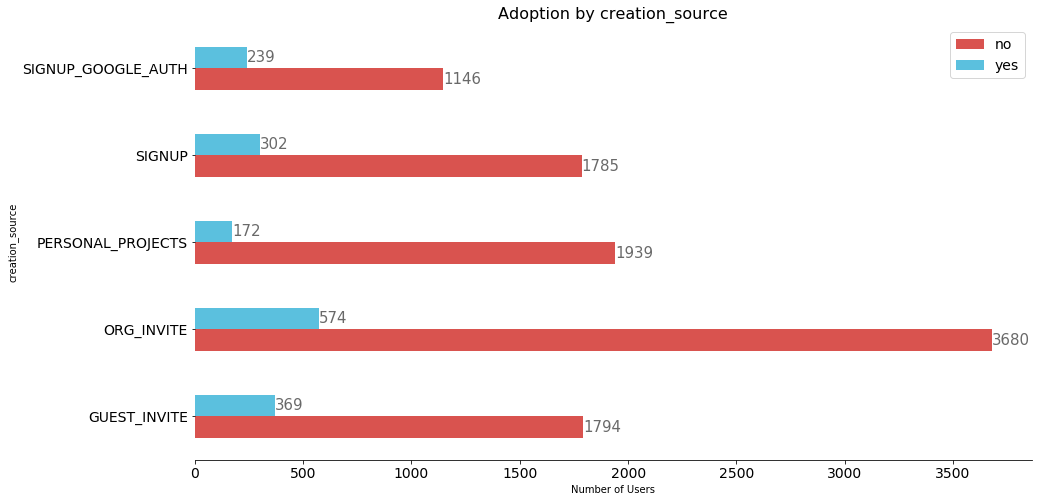

In [11]:
ax = df_adopted_users.groupby(['adopted'])['creation_source'].value_counts().unstack(0).plot.barh(figsize=(15,8),
                                                                                   width=0.5,
                                                                                   color=['#d9534f', '#5bc0de'],
                                                                                   fontsize=14)

plt.legend(fontsize=14)
plt.title("Adoption by creation_source",
         fontsize=16)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_width(), i.get_y()+.075, \
            str(int(i.get_width())), fontsize=15,
                color='dimgrey', clip_on=True)

ax.set_xlabel('Number of Users')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

Looking at the ratios of adopted users to non-adopted users, looks like the ones who created their accounts for personal projects are least likely to become an adopted user, and guest invites are the ones who are most likely to become adopted users. Overall though it doesn't look like creation_source is a a huge predictor for determining adoption. Let's take a look at other features using sklearn's ExtraTreesClassifier.

Feature ranking:
1. org_id (0.614468)
2. invited_by_user_id (0.354059)
3. opted_in_to_mailing_list (0.009056)
4. enabled_for_marketing_drip (0.008146)
5. personal_projects (0.007536)
6. guest_invite (0.002477)
7. signup_google_auth (0.001876)
8. org_invite (0.001444)
9. signup (0.000938)


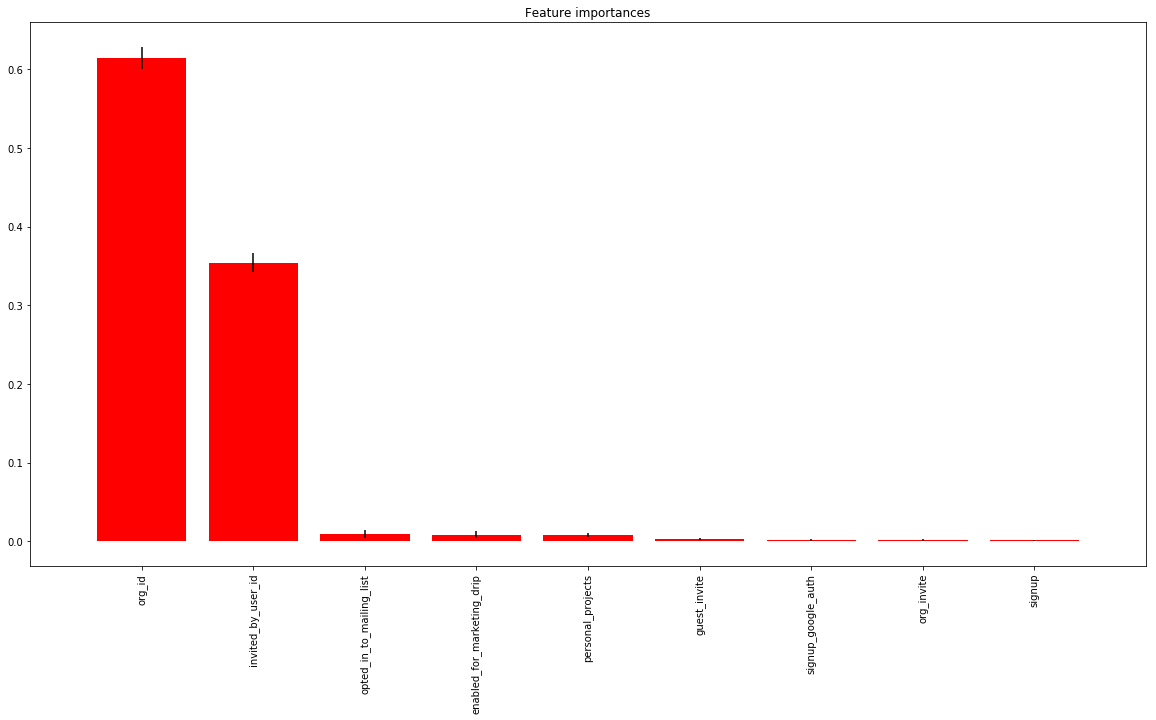

In [12]:
# imputing missing values with the mean using sklearn's SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)

# selecting all features to compute importance
features = df_adopted_users.columns[6:15]
X_train = df_adopted_users[features]

# setting target variable
y_train = df_adopted_users.loc[:,'adopted']


# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(imp_mean.fit_transform(X_train), y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = [X_train.columns[index] for index in indices] #reordering features by importance
sorted_importances = [importances[index] for index in indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), features)
plt.xticks(rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Looks like the organization the user belongs to, and who invited them are the largest factors in considering future adopted users. The next three important features opted_into_mailing_list, enabled_for_marketing_drip, and personal_project should be considered equally important as their weights relatively the same, but still not nearly as important as the the top two. The last four features seem to be of very little relevance.